* If you fit the monthly variations

# Crime and Weather

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
sns.set(font_scale = 1.3)

import pytz
import datetime

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

/home/jsaxon/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Variations in Chicago.
We are well-acquainted with the correlated variation in crime and weather, in Chicago.

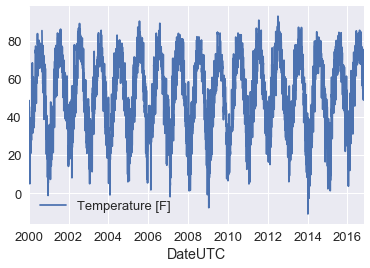

In [2]:
weather_mdw = pd.read_csv("/media/jsaxon/brobdingnag/data/weather/MDW.csv", 
                          index_col = "DateUTC", parse_dates = ["DateUTC"], 
                          usecols = ["DateUTC", "Temperature [F]", "Precipitation [In]"])

weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

weather_mdw = weather_mdw[["Temperature [F]"]].resample("1D").mean()
weather_mdw.plot(y = "Temperature [F]", figsize = (6, 4))

In [3]:
# This is just wildly faster by command line.
# If need be, we can make it python
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv \
#       | cut -f3 -d"," | cut -f1 -d " " \
#       | sed "s/\(..\)\/\(..\)\/\(....\)/\3\/\1\/\2/" \
#       | sort | uniq -c | grep -v "[A-Z]" \
#       > chicago_crime_counts.csv

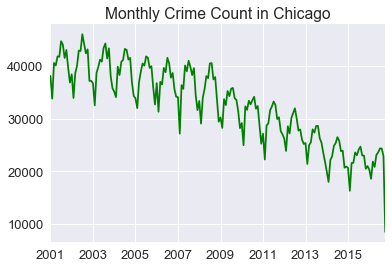

In [4]:
daily_crimes = pd.read_csv("chicago_crime_counts.csv", index_col = "Date", parse_dates = True,
                           delim_whitespace = True, names = ["Count", "Date"])

daily_crimes.set_index(daily_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True)
ax = daily_crimes["Count"].resample("1M").sum().plot(c = "g", figsize = (6, 4), title = "Monthly Crime Count in Chicago")
ax.set_xlabel("")

## Warm Places: It's Not Sunlight
Loading crime data from San Francisco, Dallas, and Phoenix (grouped at the monthly level) suggests that the temperature variations are actually importnt: it's not just daylight or the school calendar.

In [7]:
sf_crime = pd.read_csv("/media/jsaxon/brobdingnag/data/crime/san_francisco_ca.csv", 
                       usecols = ["Date", "Time", "Category"], 
                       parse_dates = [["Date", "Time"]], index_col = "Date_Time")

sf_crime = sf_crime[sf_crime["Category"] != "NON-CRIMINAL"]

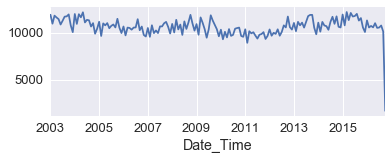

In [8]:
sf_crime["Category"].resample("1M").count().plot(figsize = (6, 2))

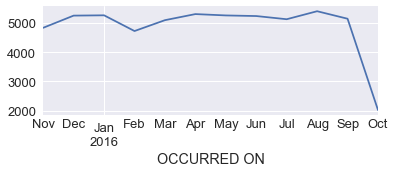

In [9]:
phoenix_crime = pd.read_csv("/media/jsaxon/brobdingnag/data/crime/phoenix_az.csv",
                            parse_dates = ["OCCURRED ON"], index_col = "OCCURRED ON",
                            usecols = ["UCR CRIME CATEGORY", "OCCURRED ON"])
phoenix_crime["UCR CRIME CATEGORY"].resample("1M").count().plot(figsize = (6, 2))

In [10]:
dallas_crime = pd.read_csv("/media/jsaxon/brobdingnag/data/crime/dallas_tx.csv",
                           usecols = ["Date1", "Time1", "OffIncident"], 
                           parse_dates = [["Date1", "Time1"]],
                           index_col = "Date1_Time1")

non_criminal = dallas_crime["OffIncident"].str.contains("NO OFFENSE") | dallas_crime["OffIncident"].str.contains("ACCIDENT INV")
dallas_crime = dallas_crime[~non_criminal]

dallas_crime.set_index(pd.DatetimeIndex(dallas_crime.index), inplace = True)

dallas_crime = dallas_crime[dallas_crime.index.date > datetime.date(2014, 10, 1)]

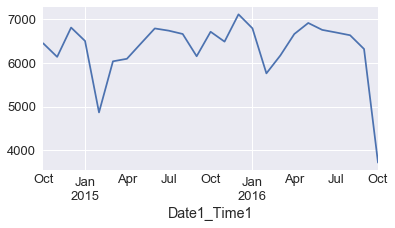

In [11]:
dallas_crime["OffIncident"].resample("1M").count().plot(figsize = (6, 3))

### The Question is, what drives the variation?
Is it the absolute temperature, the temperature relative to neighboring days, or both?  Let's construct a few measures:

In [5]:
# This is the running average of neighboring weeks.
# The problem is that it remains correlated with the day in question.
weather_mdw['Split Window [F]'] = 0.5 * (weather_mdw['Temperature [F]'].rolling(window = 7, center = False).mean().shift(-7) +
                                         weather_mdw['Temperature [F]'].rolling(window = 7, center = False).mean().shift(1))

# The shift, using the same measure.
weather_mdw['Split Shift [F]']  = weather_mdw['Temperature [F]'] - weather_mdw['Split Window [F]']

# The rolling monthly mean.
weather_mdw['Monthly Mean [F]'] = weather_mdw['Temperature [F]'].rolling(window = 30, center = True).mean()

weather_mdw.dropna(inplace = True)

There do not seem to be significant trends in the short-term shift comparisons, by season.

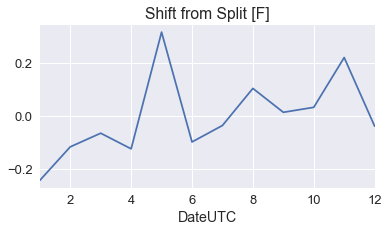

In [6]:
weather_mdw["Split Shift [F]"].groupby(weather_mdw.index.month).mean().plot(figsize = (6, 3), title = "Shift from Split [F]")

Create similar ratios for crime:  We want to be able to look for changes in the daily crime counts, from daily temperature changes.

In [7]:
daily_crimes['Two Week Split [Count]'] = 0.5 * (daily_crimes['Count'].rolling(window = 7, center = False).mean().shift(-7) +
                                                daily_crimes['Count'].rolling(window = 7, center = False).mean().shift(1))

daily_crimes['Two Week Ratio [Count]'] = daily_crimes['Count'] / daily_crimes['Two Week Split [Count]']
daily_crimes.dropna(inplace = True)

Merge the two datasets.  Crime and year variables will be useful, since there are strong trends by year in the Chicago data.

In [23]:
cw = pd.concat([weather_mdw, daily_crimes], axis = 1).dropna()
cw.set_index(pd.DatetimeIndex(cw.index), inplace = True)
cw["Month"] = cw.index.month
cw["Year"]  = cw.index.year
cw["Day of Week"] = cw.index.dayofweek

A 'fairly strong' dependence remains in the daily variations.

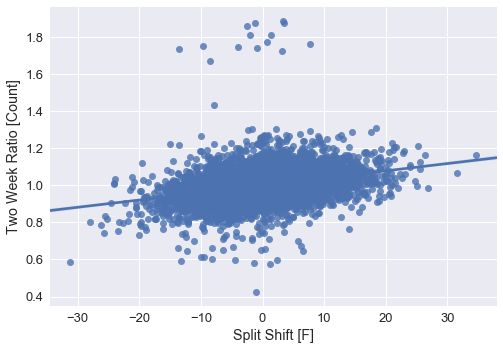

In [9]:
sns.regplot(x = "Split Shift [F]", y = "Two Week Ratio [Count]", data = cw)

The coefficient is highly significant.

In [96]:
ols = smf.ols(formula = "NC ~ T + Y",
              data = cw.rename(columns = {"Count" : "NC", 
                                          "Two Week Ratio [Count]" : "CR2W",
                                          "Temperature [F]"  : "T", 
                                          "Monthly Mean [F]" : "MT",
                                          "Split Window [F]" : "SSp", 
                                          "Split Shift [F]"  : "SSh",
                                          "Year"             : "Y",
                                          "Month"            : "M",
                                          "Day of Week"      : "W"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 1.462e+04
Date:                Wed, 13 Sep 2017   Prob (F-statistic):               0.00
Time:                        19:22:24   Log-Likelihood:                -34668.
No. Observations:                5750   AIC:                         6.934e+04
Df Residuals:                    5747   BIC:                         6.936e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    9.41e+04    585.761    160.644      0.000     9.3e+04    9.52e+04
T              4.3656      0.067     64.913      0.000       4.234       4.497
Y            -46.4320      0.292   -159.189      0.000     -47.004     -45.860
==============================================================================
Omnibus:                     1252.079   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11281.291
Skew:                           0.783   Prob(JB):                         0.00
Kurtosis:                       9.681   Cond. No.                     8.88e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

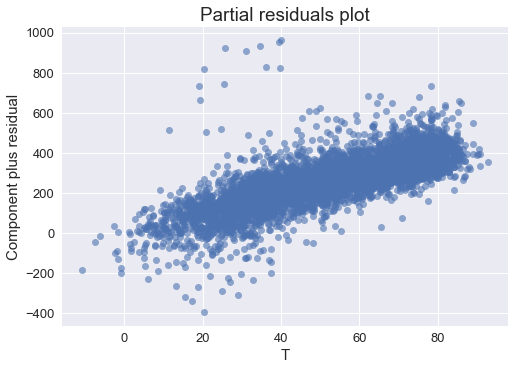

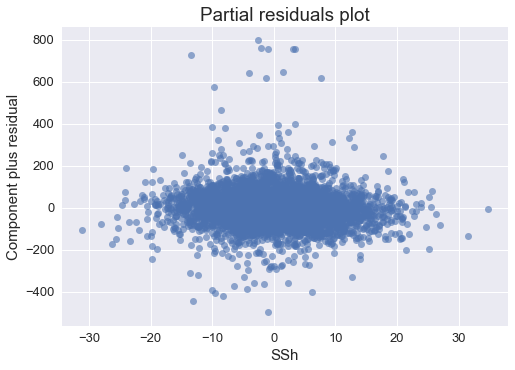

In [56]:
import statsmodels.graphics as smg
ax = smg.regressionplots.plot_partial_residuals(model, 33)
ax = smg.regressionplots.plot_partial_residuals(model, 34)

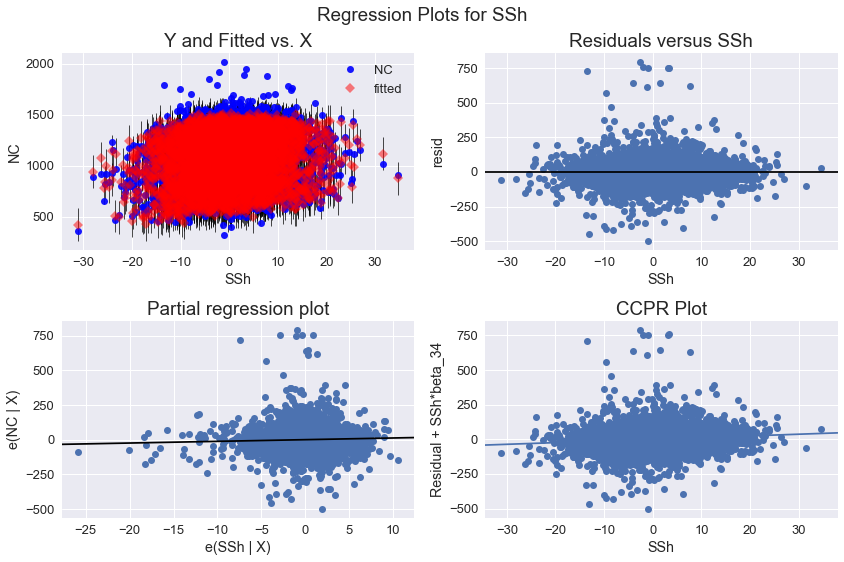

In [30]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 34, fig = fig)

# Non-Linear Least Squares
Try absolute value or a quadratic to find the "best" temperature to mug at.

In [114]:
import numpy as np
from lmfit import minimize, Parameters, report_fit

In [115]:
def residual_kink(vars, T, Y, data):
    
    base   = vars["base"]
    Topt   = vars["Topt"]
    betaT  = vars["betaT"]
    betaTh = vars["betaTh"]
    betaY  = vars["betaY"]

    model = base + np.where(T < Topt, T * betaT, Topt*betaT + (T - Topt) * betaTh) * betaT + (Y - 2000) * betaY

    return (data - model) / np.sqrt(data)


params = Parameters()
params.add('betaT', value = 2.4,  min = 0, max = 10)
params.add('betaTh', value = 1.4,  min =-3, max = 3)
params.add('betaY', value = -47,  min = -70, max = -30)
params.add('Topt', value = 47,  min = 0,  max = 120)
params.add('base', value = 1.2e3, min = 0,   max = 2e3)

out = minimize(residual_kink, params, 
               args=(cw["Temperature [F]"], cw["Year"], cw["Count"]),
               method = "leastsq")

report_fit(out)

[[Fit Statistics]]
    # function evals   = 54
    # data points      = 5750
    # variables        = 5
    chi-square         = 52623.428
    reduced chi-square = 9.160
    Akaike info crit   = 12740.279
    Bayesian info crit = 12773.564
[[Variables]]
    betaT:    2.37860482 +/- 0.037287 (1.57%) (init= 2.4)
    betaTh:   1.42399857 +/- 0.073029 (5.13%) (init= 1.4)
    betaY:   -47.0441570 +/- 0.277616 (0.59%) (init=-47)
    Topt:     47.1727359 +/- 2.165493 (4.59%) (init= 47)
    base:     1189.00439 +/- 6.486837 (0.55%) (init= 1200)
[[Correlations]] (unreported correlations are <  0.100)
    C(betaT, base)               = -0.870 
    C(betaT, Topt)               = -0.573 
    C(betaY, base)               = -0.429 
    C(betaTh, Topt)              = -0.427 
    C(Topt, base)                =  0.380 
    C(betaT, betaTh)             = -0.307 
    C(betaTh, base)              =  0.280 


In [116]:
params = Parameters()
params.add('betaT', value = 0,  min = -5, max = 5)
params.add('betaY', value = -46,  min = -100, max = 0)
params.add('Topt', value = 50,  min = 0,  max = 200)
params.add('base', value = 1.2e3, min = 0,   max = 2000)

def residual_quad(vars, T, Y, data):
    
    base  = vars["base"]
    Topt  = vars["Topt"]
    betaT = vars["betaT"]
    betaY = vars["betaY"]

    model = base + np.power(Topt - T, 2) * betaT + (Y - 2000) * betaY

    return (data - model) / np.sqrt(data)


out = minimize(residual_quad, params, 
               args=(cw["Temperature [F]"], cw["Year"], cw["Count"]),
               method = "leastsq")

report_fit(out)

[[Fit Statistics]]
    # function evals   = 33
    # data points      = 5750
    # variables        = 4
    chi-square         = 52692.600
    reduced chi-square = 9.170
    Akaike info crit   = 12745.832
    Bayesian info crit = 12772.460
[[Variables]]
    betaT:  -0.02730289 +/- 0.003059 (11.21%) (init= 0)
    betaY:  -47.0291139 +/- 0.277909 (0.59%) (init=-46)
    Topt:    129.475156 +/- 9.163941 (7.08%) (init= 50)
    base:    1632.34719 +/- 19.88111 (1.22%) (init= 1200)
[[Correlations]] (unreported correlations are <  0.100)
    C(betaT, Topt)               =  0.992 
    C(Topt, base)                =  0.981 
    C(betaT, base)               =  0.957 
    C(betaY, base)               = -0.191 


* Estimating it with an absolute value gives you an "optimal" temperature of 72°; using a quadratic, you get 85°.
* A better measure might be to focus on periods of the day short enough for the temperature to actually exceed comfortable thresholds.  Let's try 12h - 18h, in Chicago, for which the daily trend is as follows:

In [136]:
weather_mdw = pd.read_csv("/media/jsaxon/brobdingnag/data/weather/MDW.csv", 
                          index_col = "DateUTC", parse_dates = ["DateUTC"], 
                          usecols = ["DateUTC", "Temperature [F]", "Precipitation [In]"])

weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

In [137]:
afternoon_weather = weather_mdw[(12 <= weather_mdw.index.hour) & (weather_mdw.index.hour < 18)]
afternoon_avg_temp = pd.DataFrame(afternoon_weather["Temperature [F]"].resample("1D").mean())

In [138]:
# This is just wildly faster by command line.
# If need be, we can make it python
! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv \
      | cut -f3 -d"," | grep PM | grep " [01][12345]" \
      | cut -f1 -d " " \
      | sed "s/\(..\)\/\(..\)\/\(....\)/\3\/\1\/\2/" \
      | sort | uniq -c | grep -v "[A-Z]" \
      > chicago_afternoon_crime_counts.csv

In [139]:
afternoon_crimes = pd.read_csv("chicago_afternoon_crime_counts.csv", index_col = "Date", parse_dates = True,
                           delim_whitespace = True, names = ["Count", "Date"])

afternoon_crimes.set_index(afternoon_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True)

In [140]:
ct_mdw = pd.concat([afternoon_avg_temp, afternoon_crimes], axis = 1).dropna()

In [151]:
from lmfit import minimize, Parameters

params = Parameters()
params.add('betaT', value = 0,   min = -20, max = 20)
params.add('betaY', value = -16, min = -50, max = 50, vary = True)
params.add('Topt',  value = 60,  min = 40,  max = 100, vary = True)
params.add('base',  value = 550, min = 0,   max = 1e5)

out = minimize(residual_abs, params, 
               args=(ct_mdw["Temperature [F]"], ct_mdw.index.year, cam["Count"]))
print("ABS:", out.params)
print("ABS chi2/ndof", out.chisqr / out.nfree)
print()


out = minimize(residual_quad, params, 
               args=(ct_mdw["Temperature [F]"], ct_mdw.index.year, cam["Count"]))
print("QUAD:", out.params)
print("QUAD chi2/ndof", out.chisqr / out.nfree)


ABS: Parameters([('betaT', <Parameter 'betaT', value=0.0 +/- 0, bounds=[-20:20]>), ('betaY', <Parameter 'betaY', value=-16.0 +/- 0, bounds=[-50:50]>), ('Topt', <Parameter 'Topt', value=60.0 +/- 0, bounds=[40:100]>), ('base', <Parameter 'base', value=550.00015674948054 +/- 0, bounds=[0:100000.0]>)])
ABS chi2/ndof nan

QUAD: Parameters([('betaT', <Parameter 'betaT', value=0.0 +/- 0, bounds=[-20:20]>), ('betaY', <Parameter 'betaY', value=-16.0 +/- 0, bounds=[-50:50]>), ('Topt', <Parameter 'Topt', value=60.0 +/- 0, bounds=[40:100]>), ('base', <Parameter 'base', value=550.00015674948054 +/- 0, bounds=[0:100000.0]>)])
QUAD chi2/ndof nan


Need to implement model, to `guess` and plot towards appropriate parameters -- this seems funky.

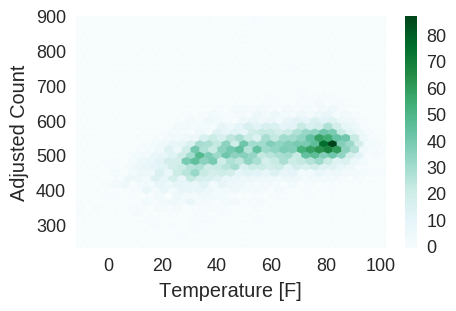

In [142]:
ct_mdw["Adjusted Count"] = ct_mdw["Count"] + 16.2 * (ct_mdw.index.year - 2000)
ct_mdw.plot.hexbin(gridsize = 35, x = "Temperature [F]", y = "Adjusted Count", figsize = (5, 3), sharex=False)

Suggests the use of a profile plot.

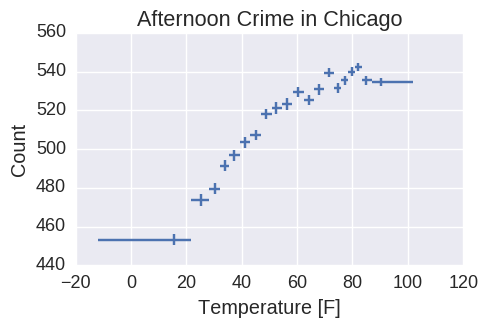

In [149]:
fig, ax = plt.subplots(figsize=(5, 3))
binned_df = ct_mdw.groupby(pd.qcut(ct_mdw["Temperature [F]"], 20))
ax.errorbar(x = binned_df.mean()["Temperature [F]"], 
            y = binned_df.mean()["Adjusted Count"],
            xerr = [binned_df.mean()["Temperature [F]"] - binned_df.min()["Temperature [F]"], 
                    binned_df.max()["Temperature [F]"] - binned_df.mean()["Temperature [F]"]],
            yerr = binned_df.std()["Adjusted Count"] / np.sqrt(binned_df.count()["Adjusted Count"]), 
            fmt="none", figsize = (5, 3))
ax.set(xlabel = "Temperature [F]", ylabel = "Count", title = "Afternoon Crime in Chicago")

### We would hope to see the turn-over, more clearly, in Phoenix.

In [144]:
# This is just wildly faster by command line.
# If need be, we can make it python
! cat /media/jsaxon/brobdingnag/data/crime/phoenix_az.csv \
      | cut -d, -f2 | grep "  1[2-7]:" | cut -f1 -d " " \
      | sed "s/\(..\)\/\(..\)\/\(....\)/\3\/\1\/\2/" \
      | sort | uniq -c | grep -v "[A-Z]" \
      > phoenix_afternoon_crime_counts.csv

In [145]:
phx_afternoon_crimes = pd.read_csv("phoenix_afternoon_crime_counts.csv", index_col = "Date", parse_dates = True,
                           delim_whitespace = True, names = ["Count", "Date"])

phx_afternoon_crimes.set_index(phx_afternoon_crimes.index.tz_localize(pytz.timezone('US/Mountain')), inplace = True)

In [146]:
weather_phx = pd.read_csv("/media/jsaxon/brobdingnag/data/weather/PHX.csv", 
                          index_col = "DateUTC", parse_dates = ["DateUTC"], 
                          usecols = ["DateUTC", "Temperature [F]", "Precipitation [In]"])

weather_phx.set_index(weather_phx.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Mountain')), inplace = True)

phx_afternoon_weather = weather_phx[(12 <= weather_phx.index.hour) & (weather_phx.index.hour < 18)]
phx_afternoon_avg_temp = pd.DataFrame(phx_afternoon_weather["Temperature [F]"].resample("1D").mean())

In [147]:
ct_phx = pd.concat([phx_afternoon_avg_temp, phx_afternoon_crimes], axis = 1).dropna()

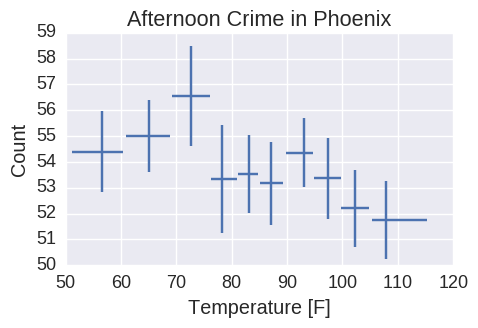

In [148]:
fig, ax = plt.subplots(figsize=(5, 3))
binned_df = ct_phx.groupby(pd.qcut(ct_phx["Temperature [F]"], 10))
ax.errorbar(x = binned_df.mean()["Temperature [F]"], 
            y = binned_df.mean()["Count"],
            xerr = [binned_df.mean()["Temperature [F]"] - binned_df.min()["Temperature [F]"], 
                    binned_df.max()["Temperature [F]"] - binned_df.mean()["Temperature [F]"]],
            yerr = binned_df.std()["Count"] / np.sqrt(binned_df.count()["Count"]), 
            fmt="none", figsize = (5, 3))
ax.set(xlabel = "Temperature [F]", ylabel = "Count", title = "Afternoon Crime in Phoenix")